<a href="https://colab.research.google.com/github/david-franz/CNN-Skin-Cancer-Detector/blob/main/paper_params_cnn_baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# CNN Baseline (Paper Params)


## 1. Setup

In [ ]:

import os, math, time, json, random
from pathlib import Path

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.optim import Adam
from torchvision import datasets, transforms

import numpy as np

# Reproducibility
def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cuda')

## 2. Data

In [ ]:
import math, time
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torch.nn as nn
from torchvision.transforms import ToTensor
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

import os
import pandas as pd
from PIL import Image
from IPython.display import Image as IPythonImage

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("nodoubttome/skin-cancer9-classesisic")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'skin-cancer9-classesisic' dataset.
Path to dataset files: /kaggle/input/skin-cancer9-classesisic


In [ ]:
base_filepath = path + '/Skin cancer ISIC The International Skin Imaging Collaboration'

# Example of a simple preprocessing function
def preprocess_image(image_path, target_size=(28, 28)):
    img = Image.open(image_path).resize(target_size)
    return ToTensor()(img)

data = []
classes = os.listdir(base_filepath + '/Train')
for tt in os.listdir(base_filepath):
    for type in classes:
        for file in os.listdir(base_filepath + '/' + tt + '/' + type):
            constructed_filepath = base_filepath + '/' + tt + '/' + type + '/' + file
            data.append({'label': type, 'image': preprocess_image(constructed_filepath)})

In [ ]:
len(data)

2357

In [ ]:
from torch.utils.data import random_split, TensorDataset

def get_data_split(d, train_percentage=0.72):
    data = d.copy()
    random.shuffle(data)

    if train_percentage < 0 or train_percentage > 1:
        raise ValueError("train_percentage must be between 0 and 1")

    data_length = len(data)

    train_size = int(train_percentage * data_length)
    test_size = int((1 - train_percentage) * 0.72 * data_length)
    val_size = data_length - train_size - test_size

    print(train_size)

    train_dataset, val_dataset, test_dataset = random_split(data, [train_size, val_size, test_size])

    return train_dataset, test_dataset, val_dataset

In [ ]:
data_train, data_test, data_val = get_data_split(data)

1697


In [ ]:
print(len(data_train))
print(len(data_test))
print(len(data_val))

1697
475
185


In [ ]:
def time_function(func):
    start_time = time.time()
    func()
    end_time = time.time()
    return end_time - start_time

In [ ]:
# Separate images and labels
train_images = torch.stack([item['image'] for item in data_train])
test_images = torch.stack([item['image'] for item in data_test])
val_images = torch.stack([item['image'] for item in data_val])

# Get unique labels and create a mapping
unique_labels = sorted(list(set([item['label'] for item in data])))
label_to_int = {label: i for i, label in enumerate(unique_labels)}

# Convert string labels to numerical labels
train_labels = torch.tensor([label_to_int[item['label']] for item in data_train], dtype=torch.long)
test_labels = torch.tensor([label_to_int[item['label']] for item in data_test], dtype=torch.long)
val_labels = torch.tensor([label_to_int[item['label']] for item in data_val], dtype=torch.long)

# Create TensorDatasets
train_dataset = TensorDataset(train_images, train_labels)  # Convert data to tensors
test_dataset = TensorDataset(test_images, test_labels)  # Convert data to tensors
val_dataset = TensorDataset(val_images, val_labels)  # Convert data to tensors

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

## 3. Model (3× Conv → Pool+BN; Flatten → Dense×3 w/ Dropout)

In [ ]:

class PaperStyleCNN(nn.Module):
    def __init__(self, num_classes: int):
        super().__init__()
        # Three conv blocks: Conv(3x3) → MaxPool(2x2) → BatchNorm → ReLU
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1, bias=False)
        self.bn1   = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1, bias=False)
        self.bn2   = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1, bias=False)
        self.bn3   = nn.BatchNorm2d(128)

        # After 3 × MaxPool(2), spatial dims reduce: img_size / 2 / 2 / 2
        with torch.no_grad():
            dummy = torch.zeros(1, 3, 28, 28)
            h = self._forward_features(dummy)
            flat_dim = h.numel()

        self.dropout = nn.Dropout(p=0.5)
        self.fc1 = nn.Linear(flat_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.out = nn.Linear(32, num_classes)

    def _forward_features(self, x):
        x = F.relu(self.bn1(F.max_pool2d(self.conv1(x), 2)))
        x = F.relu(self.bn2(F.max_pool2d(self.conv2(x), 2)))
        x = F.relu(self.bn3(F.max_pool2d(self.conv3(x), 2)))
        return torch.flatten(x, 1)

    def forward(self, x):
        x = self._forward_features(x)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))
        return self.out(x)

model = PaperStyleCNN(num_classes=len(classes)).to(device)
sum(p.numel() for p in model.parameters()), model


(251689,
 PaperStyleCNN(
   (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
   (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
   (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
   (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (dropout): Dropout(p=0.5, inplace=False)
   (fc1): Linear(in_features=1152, out_features=128, bias=True)
   (fc2): Linear(in_features=128, out_features=64, bias=True)
   (fc3): Linear(in_features=64, out_features=32, bias=True)
   (out): Linear(in_features=32, out_features=9, bias=True)
 ))

## 4. Training Setup

In [ ]:

epochs = 100
lr = 1e-4
criterion = nn.CrossEntropyLoss()  # for mutliclass classification
optimizer = Adam(model.parameters(), lr=lr)

def accuracy_from_logits(logits, targets):
    preds = torch.argmax(logits, dim=1)
    return (preds == targets).float().mean().item()

best_val_acc = 0.0
history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}


## 5. Train

In [ ]:
def train_model(model, train_loader, val_loader, epochs, optimizer, criterion, device, best_val_acc):
  for epoch in range(1, epochs + 1):
      model.train()
      train_loss, train_acc, n_train = 0.0, 0.0, 0
      for images, targets in train_loader:
          images, targets = images.to(device), targets.to(device)
          optimizer.zero_grad()
          logits = model(images)
          loss = criterion(logits, targets)
          loss.backward()
          optimizer.step()

          bsz = targets.size(0)
          train_loss += loss.item() * bsz
          train_acc  += accuracy_from_logits(logits, targets) * bsz
          n_train    += bsz

      train_loss /= max(n_train, 1)
      train_acc  /= max(n_train, 1)

      model.eval()
      val_loss, val_acc, n_val = 0.0, 0.0, 0
      with torch.inference_mode():
          for images, targets in val_loader:
              images, targets = images.to(device), targets.to(device)
              logits = model(images)
              loss = criterion(logits, targets)

              bsz = targets.size(0)
              val_loss += loss.item() * bsz
              val_acc  += accuracy_from_logits(logits, targets) * bsz
              n_val    += bsz

      val_loss /= max(n_val, 1)
      val_acc  /= max(n_val, 1)

      history["train_loss"].append(train_loss)
      history["train_acc"].append(train_acc)
      history["val_loss"].append(val_loss)
      history["val_acc"].append(val_acc)

      if val_acc > best_val_acc:
          best_val_acc = val_acc
          torch.save(model.state_dict(), "paper_style_cnn_best.pt")

      print(f"Epoch [{epoch:02d}/{epochs}]  "
            f"Train Loss: {train_loss:.4f} | Acc: {train_acc:.4f}  "
            f"Val Loss: {val_loss:.4f} | Acc: {val_acc:.4f}  "
            f"(best val acc: {best_val_acc:.4f})")


In [ ]:
timeit = time_function(lambda: train_model(model, train_loader, val_loader, epochs, optimizer, criterion, device, best_val_acc))

Epoch [01/250]  Train Loss: 2.2213 | Acc: 0.0577  Val Loss: 2.2156 | Acc: 0.0757  (best val acc: 0.0757)
Epoch [02/250]  Train Loss: 2.2075 | Acc: 0.0801  Val Loss: 2.1946 | Acc: 0.0757  (best val acc: 0.0757)
Epoch [03/250]  Train Loss: 2.1823 | Acc: 0.1126  Val Loss: 2.1518 | Acc: 0.1892  (best val acc: 0.1892)
Epoch [04/250]  Train Loss: 2.1622 | Acc: 0.1326  Val Loss: 2.1095 | Acc: 0.1838  (best val acc: 0.1892)
Epoch [05/250]  Train Loss: 2.1274 | Acc: 0.1691  Val Loss: 2.0540 | Acc: 0.1838  (best val acc: 0.1892)
Epoch [06/250]  Train Loss: 2.0868 | Acc: 0.1862  Val Loss: 1.9978 | Acc: 0.1838  (best val acc: 0.1892)
Epoch [07/250]  Train Loss: 2.0500 | Acc: 0.2045  Val Loss: 1.9482 | Acc: 0.1892  (best val acc: 0.1892)
Epoch [08/250]  Train Loss: 2.0229 | Acc: 0.2033  Val Loss: 1.9088 | Acc: 0.1946  (best val acc: 0.1946)
Epoch [09/250]  Train Loss: 2.0099 | Acc: 0.2157  Val Loss: 1.8849 | Acc: 0.2162  (best val acc: 0.2162)
Epoch [10/250]  Train Loss: 1.9770 | Acc: 0.2463  Val L

In [ ]:
print(timeit)

32.1970374584198


## 6. Curves

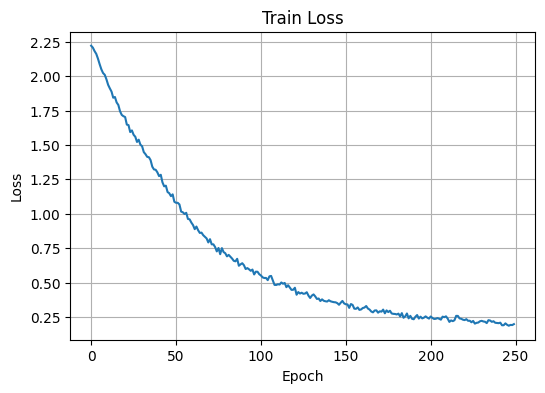

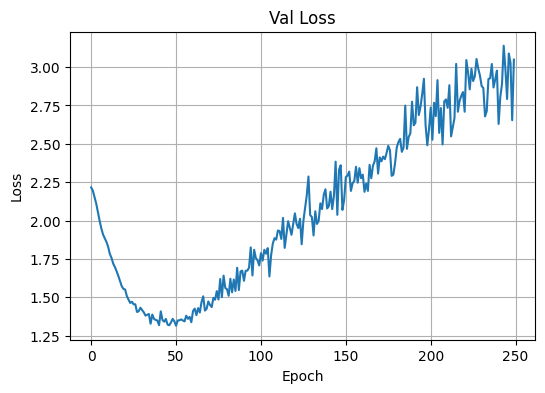

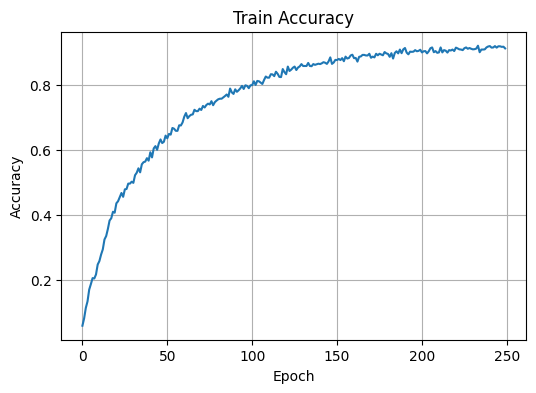

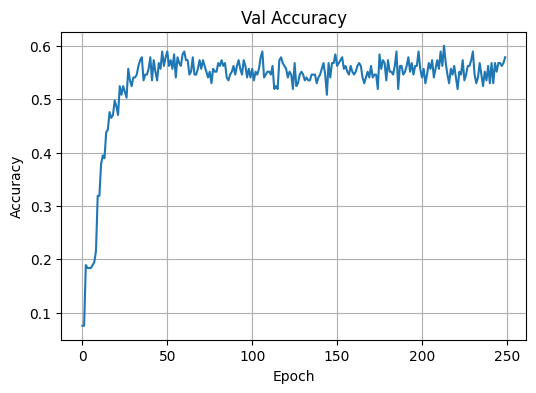

In [ ]:

import matplotlib.pyplot as plt

def plot_curve(values, title, ylabel):
    plt.figure(figsize=(6,4))
    plt.plot(values)
    plt.title(title)
    plt.xlabel("Epoch")
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.show()

plot_curve(history["train_loss"], "Train Loss", "Loss")
plot_curve(history["val_loss"], "Val Loss", "Loss")
plot_curve(history["train_acc"], "Train Accuracy", "Accuracy")
plot_curve(history["val_acc"], "Val Accuracy", "Accuracy")


## 7. Evaluation

In [ ]:

state_dict = torch.load("paper_style_cnn_best.pt")
model.load_state_dict(state_dict)
model.eval()
test_loss, test_acc, n_val = 0.0, 0.0, 0
with torch.inference_mode():
    for images, targets in test_loader:
        images, targets = images.to(device), targets.to(device)
        logits = model(images)
        loss = criterion(logits, targets)

        bsz = targets.size(0)
        test_loss += loss.item() * bsz
        test_acc  += (torch.argmax(logits, dim=1) == targets).float().mean().item() * bsz
        n_val    += bsz

test_loss /= max(n_val, 1)
test_acc  /= max(n_val, 1)

print(f"Test — Loss: {test_loss:.4f} | Acc: {test_acc:.4f}")

Test — Loss: 2.7284 | Acc: 0.6126


In [ ]:
import torch
from collections import defaultdict

SUPERGROUPS = {
    "cancer":    [1, 4, 5],
    "precancer": [3],
    "benign":    [0, 2, 6, 7, 8],
}

super_names = list(SUPERGROUPS.keys())
super_to_id = {name: i for i, name in enumerate(super_names)}
fine_to_super = {}
for sname, idxs in SUPERGROUPS.items():
    for i in idxs:
        fine_to_super[i] = super_to_id[sname]

def super_probs_from_logits(logits: torch.Tensor) -> torch.Tensor:
    """
    Convert [B, 9] logits -> [B, 3] superclass probabilities
    by softmax over 9 classes then summing probs within each group.
    """
    probs = torch.softmax(logits, dim=1)  # [B, 9]
    super_cols = []
    for sname in super_names:
        group = SUPERGROUPS[sname]
        super_cols.append(probs[:, group].sum(dim=1))  # [B]
    return torch.stack(super_cols, dim=1)  # [B, 3]

@torch.no_grad()
def eval_superclasses(model, loader, device):
    model.eval()
    n, correct = 0, 0
    mean_super_prob = torch.zeros(len(super_names), dtype=torch.float64)

    cm = torch.zeros(len(super_names), len(super_names), dtype=torch.int64)

    for images, targets in loader:
        images = images.to(device)
        targets = targets.to(device)

        logits = model(images)
        s_probs = super_probs_from_logits(logits)

        # map fine labels -> super labels
        super_targets = torch.tensor([fine_to_super[int(t)] for t in targets], device=device)

        # predictions at the superclass level
        super_preds = s_probs.argmax(dim=1)

        # accuracy
        correct += (super_preds == super_targets).sum().item()
        n += targets.size(0)

        # accumulate mean probs
        mean_super_prob += s_probs.sum(dim=0).cpu().double()

        # confusion matrix
        for t, p in zip(super_targets.cpu(), super_preds.cpu()):
            cm[t, p] += 1

    acc = correct / max(n, 1)

    # Normalize mean probs
    mean_super_prob = (mean_super_prob / max(n, 1)).tolist()

    print("Superclass Names:", super_names)
    print(f"Superclass Accuracy: {acc:.4f}")
    print("Mean predicted probability per superclass:")
    for name, mp in zip(super_names, mean_super_prob):
        print(f"  - {name:9s}: {mp:.4f}")

    print("\nSuperclass Confusion Matrix (rows=true, cols=pred):")
    header = "          " + " ".join([f"{n[:8]:>9}" for n in super_names])
    print(header)
    for i, row in enumerate(cm.tolist()):
        print(f"{super_names[i][:8]:>9} " + " ".join([f"{v:9d}" for v in row]))

    return {"accuracy": acc, "mean_super_prob": mean_super_prob, "confusion": cm}

super_eval = eval_superclasses(model, val_loader, device)

Superclass Names: ['cancer', 'precancer', 'benign']
Superclass Accuracy: 0.6919
Mean predicted probability per superclass:
  - cancer   : 0.5921
  - precancer: 0.2029
  - benign   : 0.2050

Superclass Confusion Matrix (rows=true, cols=pred):
             cancer  precance    benign
   cancer        86         7        16
 precance         7        25         1
   benign        17         9        17
